# Multi Lable Emotion Recogination From Text (LORA-FineTuned)

### Downloading Required Libraries

In [1]:
!pip install -q --upgrade peft accelerate  datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer,AutoModelForSequenceClassification,Trainer,TrainingArguments,DataCollatorWithPadding
from peft import LoraConfig,get_peft_model
from datasets import load_dataset,Dataset

### WandB

In [3]:
import wandb
import os
from google.colab import userdata
api_wb = userdata.get('WB_API')

wandb.login(key=api_wb)

run = wandb.init(
    project="BART Fine-Tuning-emotion-recog-from-text",
    job_type="training",
    anonymous="allow"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: haseebmanzoor1511 (haseebmanzoor1511-comsats-university-islamabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load Data

In [4]:
data = pd.read_csv("tweet_emotions.csv")

In [5]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [6]:
data.shape

(40000, 3)

In [7]:
data.isna().sum()

,0
tweet_id,0
sentiment,0
content,0


In [8]:
data.drop(columns=["tweet_id"],inplace=True)  # drop the tweet_id row

In [9]:
data = data[data["sentiment"]!="empty"]   # drop rows with empty sentiment

In [10]:
data["sentiment"].unique()

array(['sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love',
       'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

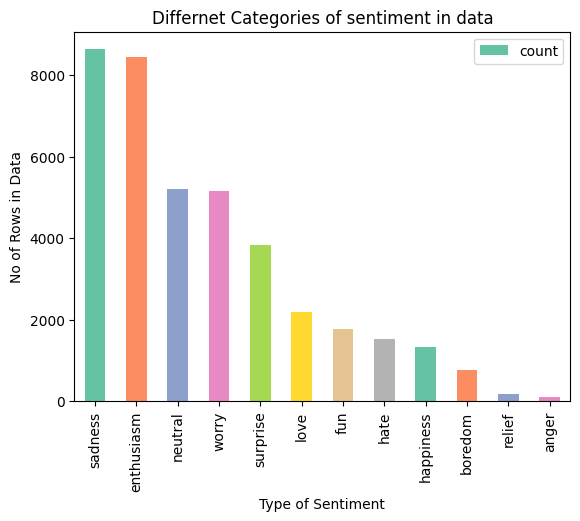

In [11]:
data["sentiment"].value_counts().plot(kind="bar",color=plt.get_cmap("Set2").colors)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],labels=['sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love','fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'])
plt.title("Differnet Categories of sentiment in data")
plt.xlabel("Type of Sentiment")
plt.ylabel("No of Rows in Data")
plt.legend()
plt.show()

In [12]:
# data = data[data["sentiment"]!="empty"]
# In this case, data is a view, not a copy, and modifying it might not behave as expected. Pandas warns you to prevent unintended bugs.
# data = data.copy()

## Label Encoding

In [13]:
data.head(10)

,sentiment,content
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
5,worry,Re-pinging @ghostridah14: why didn't you go to...
6,sadness,"I should be sleep, but im not! thinking about ..."
7,worry,Hmmm. http://www.djhero.com/ is down
8,sadness,@charviray Charlene my love. I miss you
9,sadness,@kelcouch I'm sorry at least it's Friday?
10,neutral,cant fall asleep


## Text Cleaning

In [14]:
import re
def cleaning(text):
    text = re.sub(r"http\S+", "", text)           # Remove URLs
    text = re.sub(r"@\w+", "", text)              # Remove mentions
    text = re.sub(r"#", "", text)            # Remove hashtag symbols (keep word)
    text = re.sub(r"\s+", " ", text)                # Remove extra whitespace
    return text.strip().lower()

In [15]:
data["content"] = data["content"].apply(cleaning)

In [16]:
data.to_csv("cleaned.csv")

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["sentiment"] = le.fit_transform(data["sentiment"])

In [18]:
data = data.drop(39995)  # asit was empty

In [19]:
data.head()

,sentiment,content
1,9,layin n bed with a headache ughhhh...waitin on...
2,9,funeral ceremony...gloomy friday...
3,2,wants to hang out with friends soon!
4,7,we want to trade with someone who has houston ...
5,11,re-pinging : why didn't you go to prom? bc my ...


## Model Loading

In [20]:
model_name = "bert-base-uncased"

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=12)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Target Modules Checking

In [22]:
# for checking target module and which one to inject in lora config
# These are the layers in the model where LoRA adapters will be injected.
# LoRA modifies only specific layers (like attention projection layers) rather than the whole model.
for name, module in model.named_modules():
    print(name)



bert
bert.embeddings
bert.embeddings.word_embeddings
bert.embeddings.position_embeddings
bert.embeddings.token_type_embeddings
bert.embeddings.LayerNorm
bert.embeddings.dropout
bert.encoder
bert.encoder.layer
bert.encoder.layer.0
bert.encoder.layer.0.attention
bert.encoder.layer.0.attention.self
bert.encoder.layer.0.attention.self.query
bert.encoder.layer.0.attention.self.key
bert.encoder.layer.0.attention.self.value
bert.encoder.layer.0.attention.self.dropout
bert.encoder.layer.0.attention.output
bert.encoder.layer.0.attention.output.dense
bert.encoder.layer.0.attention.output.LayerNorm
bert.encoder.layer.0.attention.output.dropout
bert.encoder.layer.0.intermediate
bert.encoder.layer.0.intermediate.dense
bert.encoder.layer.0.intermediate.intermediate_act_fn
bert.encoder.layer.0.output
bert.encoder.layer.0.output.dense
bert.encoder.layer.0.output.LayerNorm
bert.encoder.layer.0.output.dropout
bert.encoder.layer.1
bert.encoder.layer.1.attention
bert.encoder.layer.1.attention.self
bert.e

### Lora Config

In [23]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query","key","value","dense"],
    task_type="SEQ_CLS",
    bias="none",
    lora_dropout=0.05
)

In [24]:
model = get_peft_model(model,lora_config)

In [25]:
model.print_trainable_parameters()

trainable params: 1,348,620 || all params: 110,840,088 || trainable%: 1.2167


In [26]:
max_length = max(len(tokenizer.encode(word)) for word in data["content"])
max_length

96

In [27]:
def tokenization(example):
  input = tokenizer(example["content"],truncation=True,max_length=128,padding=False)
  return input

data = Dataset.from_pandas(data)

dataset = data.map(tokenization,batched=True)

dataset = dataset.rename_column("sentiment", "labels")

dataset.set_format(type="pt",columns=["input_ids","attention_mask","labels"])

Map:   0%|          | 0/39172 [00:00<?, ? examples/s]

In [28]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
split = dataset.train_test_split(test_size=0.2)
train_data = split["train"]
val_data = split["test"]

In [30]:
from sklearn.metrics import classification_report, f1_score

def compute_metrics(eval_pred):
  logits,labels = eval_pred
  preds = np.argmax(logits,axis=-1)
  return {"f1":f1_score(labels, preds, average="weighted")}


#     return {
#         "accuracy": accuracy_score(labels, preds),
#         "precision": precision_score(labels, preds, average="weighted", zero_division=0),
#         "recall": recall_score(labels, preds, average="weighted", zero_division=0),
#         "f1": f1_score(labels, preds, average="weighted")
#     }


In [33]:
trainer = Trainer(
    model = model,
    data_collator = data_collator,
    train_dataset = train_data,
    eval_dataset = val_data,
    compute_metrics = compute_metrics,
    args = TrainingArguments(
        output_dir = "/content/twitter_sentiment/checkpoint",
        save_total_limit=2,
        save_strategy = "epoch",
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 8,
        eval_strategy="epoch",
        num_train_epochs=5,
        run_name="emotion_finetuned",
        fp16 = True,
        logging_steps=500,
        logging_dir = "/content/twitter_sentiment/logs",
        learning_rate = 3e-5,
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        load_best_model_at_end=True,
        warmup_steps=500
    )
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [34]:
trainer.train()

# trainer.train(resume_from_checkpoint="./checkpoint-1000")

Epoch,Training Loss,Validation Loss,F1
1,1.837800,1.781680,0.330831
2,1.764900,1.740798,0.350961
3,1.740800,1.730175,0.351286
4,1.705700,1.722331,0.358104
5,1.709500,1.723622,0.359123


TrainOutput(global_step=9795, training_loss=1.771154965862685, metrics={'train_runtime': 1108.7925, 'train_samples_per_second': 141.311, 'train_steps_per_second': 8.834, 'total_flos': 3179899698254640.0, 'train_loss': 1.771154965862685, 'epoch': 5.0})

In [35]:
model = model.save_pretrained('content/fin-tuned/model/')
tokenizer=  tokenizer.save_pretrained("content/fin-tuned/tokenizer/")

In [36]:
from sklearn.metrics  import confusion_matrix
import seaborn as sns

output = trainer.predict(val_data)
predictions = output.predictions
labels = output.label_ids
predicted_label = np.argmax(predictions,axis=1)
print(classification_report(labels,predicted_label,target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        16
     boredom       0.00      0.00      0.00        36
  enthusiasm       0.00      0.00      0.00       145
         fun       0.00      0.00      0.00       336
   happiness       0.37      0.55      0.44      1120
        hate       0.38      0.33      0.36       262
        love       0.49      0.46      0.47       789
     neutral       0.42      0.53      0.47      1701
      relief       0.00      0.00      0.00       286
     sadness       0.40      0.21      0.28      1011
    surprise       0.00      0.00      0.00       440
       worry       0.37      0.56      0.45      1693

    accuracy                           0.40      7835
   macro avg       0.20      0.22      0.21      7835
weighted avg       0.34      0.40      0.36      7835



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

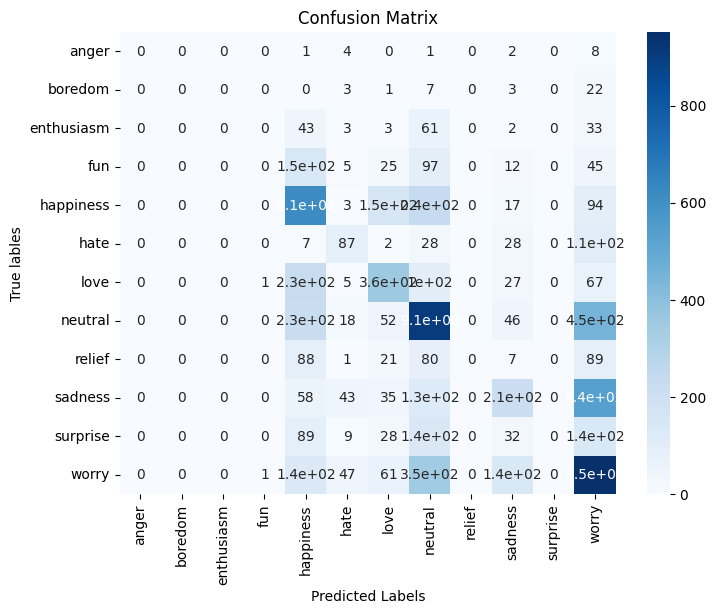

In [37]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(labels,predicted_label)
sns.heatmap(cm,annot=True,cmap="Blues",xticklabels=le.classes_,yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True lables")
plt.title("Confusion Matrix")
plt.show()

# Rows of the confusion matrix represent true labels.
# Columns represent predicted labels.

# This is the standard convention used in sklearn.metrics.confusion_matrix() and by seaborn.heatmap().
#So:
# Y-axis (vertical) → True labels
# X-axis (horizontal) → Predicted labels

In [ ]:
model = model.save_pretrained('content/fin-tuned/model/')
tokenizer=  tokenizer.save_pretrained("content/fin-tuned/tokenizer/")

In [38]:
!zip -r my_model.zip "content/fin-tuned/model/"
!zip -r tokenizer.zip "content/fin-tuned/tokenizer/"


  adding: content/fin-tuned/model/ (stored 0%)
  adding: content/fin-tuned/model/adapter_model.safetensors (deflated 7%)
  adding: content/fin-tuned/model/adapter_config.json (deflated 55%)
  adding: content/fin-tuned/model/README.md (deflated 66%)
  adding: content/fin-tuned/tokenizer/ (stored 0%)
  adding: content/fin-tuned/tokenizer/vocab.txt (deflated 53%)
  adding: content/fin-tuned/tokenizer/tokenizer_config.json (deflated 75%)
  adding: content/fin-tuned/tokenizer/tokenizer.json (deflated 71%)
  adding: content/fin-tuned/tokenizer/special_tokens_map.json (deflated 42%)
